# 07 — Oil shock analysis

Objective: identify extreme WTI return shocks (quantile rule) and estimate the average short-horizon response of XLE and ICLN around those events (event-time profiles: before / during / after).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.float_format", lambda x: f"{x:.6f}")

project_root = Path("..")

data_dir = project_root / "data"
outputs_dir = project_root / "outputs"
plots_dir = outputs_dir / "plots"
results_dir = outputs_dir / "results"

shock_dir = plots_dir / "shock"

plots_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)
shock_dir.mkdir(parents=True, exist_ok=True)

In [2]:
log_returns_path = data_dir / "log_returns_2018_2024.parquet"
assert log_returns_path.exists(), f"Missing input file: {log_returns_path}"

log_returns = pd.read_parquet(log_returns_path).sort_index()

# Align naming convention used in Notebook 03
if "CL=F" in log_returns.columns:
    log_returns = log_returns.rename(columns={"CL=F": "WTI"})

assets = ["WTI", "XLE", "ICLN"]
missing = [a for a in assets if a not in log_returns.columns]
assert not missing, f"Missing columns: {missing}"
assert log_returns.index.is_monotonic_increasing and log_returns.index.is_unique
assert log_returns.notna().all().all()

In [3]:
wti = log_returns["WTI"]

q_low, q_high = 0.05, 0.95
low_thr = wti.quantile(q_low)
high_thr = wti.quantile(q_high)

shock_mask = (wti <= low_thr) | (wti >= high_thr)
shock_dates = wti.index[shock_mask]

n_shocks = int(shock_mask.sum())
n_shocks

176

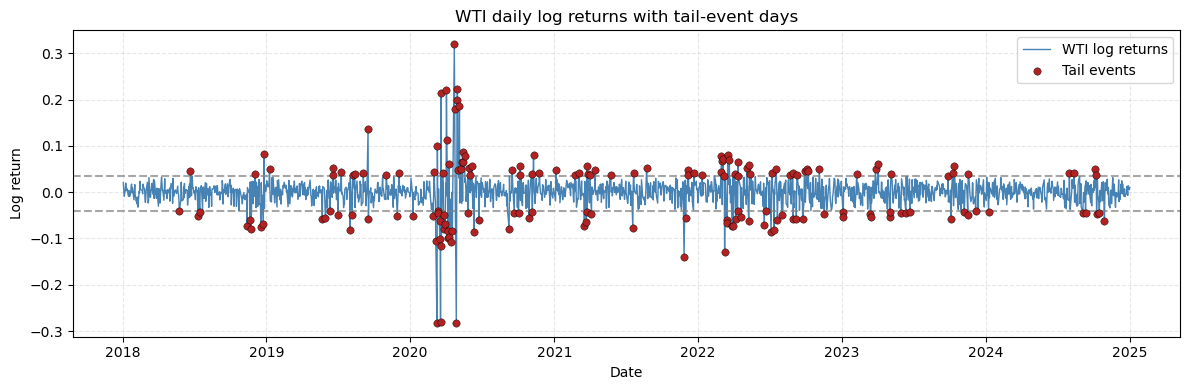

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(
    wti.index,
    wti,
    linewidth=1,
    color="steelblue",
    label="WTI log returns"
)

ax.scatter(
    shock_dates,
    wti.loc[shock_dates],
    s=28,
    color="firebrick",
    edgecolor="black",
    linewidth=0.3,
    label="Tail events",
    zorder=3
)

ax.axhline(high_thr, linestyle="--", color="grey", alpha=0.7)
ax.axhline(low_thr, linestyle="--", color="grey", alpha=0.7)

ax.set_title("WTI daily log returns with tail-event days")
ax.set_xlabel("Date")
ax.set_ylabel("Log return")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.savefig(shock_dir / "shock_timeline.png", dpi=300)
plt.show()
plt.close()

In [5]:
window = 3  # event window (±3 trading days)

assets = ["WTI", "XLE", "ICLN"]
idx = log_returns.index
pos = pd.Series(np.arange(len(idx)), index=idx)

records = []
for d in shock_dates:
    if d not in pos.index:
        continue
    p0 = int(pos.loc[d])
    p_start, p_end = p0 - window, p0 + window
    if p_start < 0 or p_end >= len(idx):
        continue  # drop edge events

    for lag in range(-window, window + 1):
        t = idx[p0 + lag]
        row = {"shock_date": d, "lag": lag}
        for a in assets:
            row[a] = float(log_returns.loc[t, a])
        records.append(row)

reaction_df = pd.DataFrame.from_records(records)

In [6]:
reaction_summary = (
    reaction_df
    .groupby("lag")[["WTI", "XLE", "ICLN"]]
    .mean()
    .sort_index()
)

reaction_summary

,WTI,XLE,ICLN
lag,,,
-3,-0.001616,-0.002805,-0.000041
-2,-0.006690,-0.003564,-0.000630
-1,0.001292,-0.000330,-0.000984
0,-0.002415,-0.001158,-0.000867
1,0.004047,0.000739,0.001312
2,0.004643,0.002129,0.000538
3,-0.000124,0.001907,-0.000872


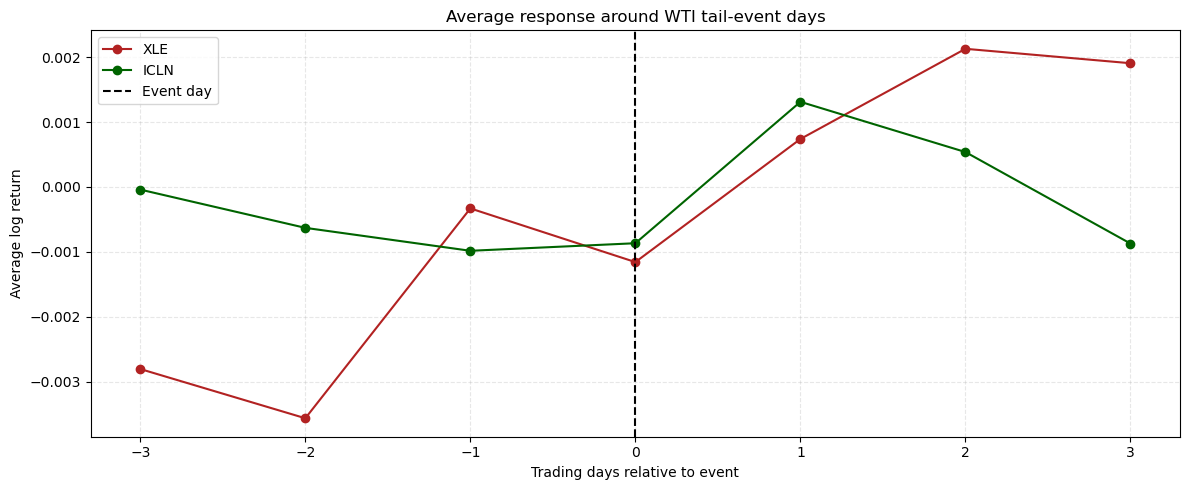

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    reaction_summary.index,
    reaction_summary["XLE"],
    marker="o",
    color="firebrick",
    label="XLE"
)

ax.plot(
    reaction_summary.index,
    reaction_summary["ICLN"],
    marker="o",
    color="darkgreen",
    label="ICLN"
)

ax.axvline(0, linestyle="--", color="black", label="Event day")

ax.set_title("Average response around WTI tail-event days")
ax.set_xlabel("Trading days relative to event")
ax.set_ylabel("Average log return")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.savefig(shock_dir / "shock_average_reaction.png", dpi=300)
plt.show()
plt.close()

In [8]:
output_path = results_dir / "oil_shock_reaction_summary.csv"
reaction_summary.to_csv(output_path)

output_path

PosixPath('../outputs/results/oil_shock_reaction_summary.csv')

## Interpretation

Using WTI tail-event days (quantile rule) and an event window of ±3 trading days, XLE exhibits a clear average co-movement around event day 0, while ICLN’s average response is smaller in magnitude.

This pattern is consistent with the economic exposure of an energy-sector ETF (XLE) to oil-price dynamics, whereas the clean-energy ETF (ICLN) appears less directly tied to short-run oil return tails in this descriptive setup.

Limits: the event definition is quantile-based (not rare “shocks”), events may cluster in time, returns are not adjusted for market-wide movements or controls, and the window length is restricted to ±3 trading days.